__author__ imthanhlv@gmail.com

# Assignment 2 - Attention and Transformers Encoder

*VietAI Advanced NLP*

Trong bài tập này chúng ta sẽ xây dựng Multihead self-attention bằng pytorch, hoàn toàn song song với nhiều queries, nhiều head và nhiều sequences trong một batch (bằng cách sử dụng broadcasting). Sau đó sẽ sử dụng thành phần này vào việc xây dựng kiến trúc Transformers.

Một số lưu ý khi bắt đầu:
- Các ký tự thường: `q`, `k`, `v` ký hiệu 1 vector / tensor 1 chiều.
- Các ký tự in hoa: `Q`, `K`, `V` ký hiệu tensor có từ 2 chiều trở lên, sẽ có trong comment từng hàm.
- Bạn cần hoàn thành các phần trong dấu:
```python
########### YOUR CODE HERE #################
###########################################
```

Chúng ta sẽ bắt đầu bằng cài đặt thư viện & một số hàm phụ trợ:

In [104]:
!pip install einops
!wget -c https://gist.githubusercontent.com/Luvata/55f7b3e9ae451122b9e3faf0a7387b4f/raw/440fac5c6e7153fd39e4eb9ebec6e51c9520ef1f/visualize.py
!pip install --upgrade graphviz

--2021-03-01 05:51:38--  https://gist.githubusercontent.com/Luvata/55f7b3e9ae451122b9e3faf0a7387b4f/raw/440fac5c6e7153fd39e4eb9ebec6e51c9520ef1f/visualize.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Requirement already up-to-date: graphviz in /usr/local/lib/python3.7/dist-packages (0.16)


In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import display_module

In [106]:
def benchmark(input_generator, slow_function, fast_function, n_tries=100):
    """
    This function will verify that the result of `slow_function` and
    `fast_function` are equals for all `n_tries` inputs from `input_generator`
    It also prints out the average run time of each function
    """
    def _one_try(input, function):
        start_time = time.time()
        output = function(*input)
        return time.time() - start_time, output
    
    def _stat_str(list_times):
        return f"AVG: {np.mean(list_times)}+-{np.std(list_times)}"
    
    slow_times = []
    fast_times = []
    
    for i in range(n_tries):
        input = next(input_generator)
        slow_time, slow_result = _one_try(input, slow_function)
        fast_time, fast_result = _one_try(input, fast_function)
        assert torch.allclose(slow_result, fast_result)
        slow_times.append(slow_time)
        fast_times.append(fast_time)
        
    print("Your outputs is correct")
    print("Timing of slow function: ", _stat_str(slow_times))  
    print("Timing of fast function: ", _stat_str(fast_times))
    print(f"Speedup: {np.mean(slow_times) / np.mean(fast_times)} times")

$d_k$, $d_v$, $n_{head}$, .. là các hyperparameters trong transformers. N_queries, M_keys là các config để test attention. `batch_size` là config để kiểm thử broadcasting với input là nhiều mẫu trong 1 lần forward.

In [107]:
d_k = 64
d_v = 64
N_queries = 32
M_keys = 32
n_head = 8
batch_size = 32

## Phần 1: Xây dựng Multi-Head Attention

Chúng ta đã biết công thức scale dot-product attention được tính như sau:
$$Attention(q, K, V) = Softmax(\frac{K^Tq}{\sqrt{d_k}}) = \sum_{i}{}\frac{e^{score(q,k_i)}}{ \sum_j e^{score(q, k_j)} }v_i$$

Với $$score(q, k) = \frac{q \cdot k}{\sqrt{d_k}}$$


Có thể thấy nếu $score(q, k_i) = -\infty \rightarrow e^{score(q, k_i)} = e^{-\infty} = 0 $ thì trọng số của $v_i$ sẽ bằng 0 nên $v_i$ sẽ không đóng góp thông tin cho kết quả attention, hay $v_i$ đã bị `mask` khi tính attention.

```
sequence              <BOS>     I    go    to    school  <EOS> <PAD> <PAD>
                        |       |     |    |       |       |     |     |
                        v       v     v    v       v       v     v     v
PAD mask                0       0     0    0       0       0     1     1 
```

Trong kiến trúc LSTM seq2seq + Attention (Bahdanau et al., Luong et al.,), attention của hidden state tại 1 bước decode tính trên embedding của $M$ tokens encoder, sẽ được sử dụng `mask` với các token `PAD` trong câu đầu vào, vì token `PAD` không mang thông tin của câu mà chỉ để chuẩn hóa độ dài các chuỗi bằng nhau.

Trong attention, việc sử dụng `mask` là cần thiết khi cần bỏ đi sự đóng góp của (k,v) không mang thông tin (vd `PAD` token) hoặc không có liên kết đến query hiện tại (vd `causal-mask` trong transformer decoder, sẽ được đề cập sau). 



Trong pytorch, `mask` trên 1 tensor được thực hiện qua hàm `masked_fill` như sau:

In [108]:
print("Original:")
similar_score = torch.tensor([[0.5, 2.3, 1.4, -1.3, 3.1]])
print("similar score  :", similar_score)
print("softmax:", F.softmax(similar_score, dim=-1))

n_step = similar_score.shape[1]
mask = torch.ones_like(similar_score).bool() # [[True, True, True, True, True]]

for step_idx in range(n_step):
    mask[0, step_idx] = False
    masked_score = similar_score.masked_fill(mask, value=-1e9)
    print(f"step #{step_idx}:", "mask:", mask, "softmax out: ", F.softmax(masked_score, dim=-1))

Original:
similar score  : tensor([[ 0.5000,  2.3000,  1.4000, -1.3000,  3.1000]])
softmax: tensor([[0.0432, 0.2615, 0.1063, 0.0071, 0.5819]])
step #0: mask: tensor([[False,  True,  True,  True,  True]]) softmax out:  tensor([[1., 0., 0., 0., 0.]])
step #1: mask: tensor([[False, False,  True,  True,  True]]) softmax out:  tensor([[0.1419, 0.8581, 0.0000, 0.0000, 0.0000]])
step #2: mask: tensor([[False, False, False,  True,  True]]) softmax out:  tensor([[0.1052, 0.6362, 0.2587, 0.0000, 0.0000]])
step #3: mask: tensor([[False, False, False, False,  True]]) softmax out:  tensor([[0.1034, 0.6253, 0.2542, 0.0171, 0.0000]])
step #4: mask: tensor([[False, False, False, False, False]]) softmax out:  tensor([[0.0432, 0.2615, 0.1063, 0.0071, 0.5819]])


Tại step #4, output của softmax bằng với kết quả softmax khi không mask. Các step còn lại, khi keys tại vị trí $i$ bị mask (`mask[0][i] == True`), thì kết quả softmax tương đương với vị trí đó bằng `0`. Một hàm scale-dot attention sử dụng mask trong pytorch có thể thực hiện như sau:

![scale-dot-product attention](https://raw.githubusercontent.com/Luvata/gifs/main/figures/scale_dot_product.png)

In [109]:
def scale_dot_product_attention(q, K, V, mask):
    """Scale-dot attentionn on a single query
    Arguments:
        q: torch.Tensor shape (1, d_k)
        K: torch.Tensor shape (M, d_k)
        V: torch.Tensor shape (M, d_v)
        mask: torch.BoolTensor shape (1, M)
        
        if mask[0, i] == True, (k, q) at index `i` will be masked
        when calculating attention
    Return:
        scaled-dot attention: torch.Tensor shape (1, d_v)
    """
    _, d_k = q.shape
    scale = d_k ** -0.5
    similar_score = q @ K.T * scale # (1, d_k) @ (d_k, M) -> (1, M)
    similar_score = similar_score.masked_fill(mask, value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1) # (1, M)
    attention = attention_weight @ V # (1, M) @ (M, d_v) -> (1, d_v)
    return attention

- `@` là phép `dot` trong pytorch
- Dòng 18: `dim=-1` là tính softmax trên axis cuối (`M`)

In [110]:
q = torch.rand(1, d_k)
K = torch.rand(M_keys, d_k)
V = torch.rand(M_keys, d_v)
mask = torch.randint(low=0, high=2, size=(1, M_keys)).bool()

print(mask)
print(scale_dot_product_attention(q, K, V, mask).shape)

tensor([[False, False, False,  True,  True,  True,  True,  True,  True, False,
         False, False, False,  True,  True,  True,  True, False,  True, False,
          True,  True, False,  True, False,  True, False,  True, False, False,
         False, False]])
torch.Size([1, 64])


### 1.1 Broadcasting với nhiều queries

*Khởi động*

Hàm `scale_dot_product_attention` trên chỉ hoạt động với 1 query. Trong phần này bạn cần hoàn thành hàm `queries_attention` song song (bằng cách sử dụng broadcasting) với `N` queries. Kết quả đầu ra cần giống với `slow_queries_attention`. Lưu ý trong phần này $mask \in \mathbb{R}^{N \times  M}$  với `mask[i]` là vector mask của `Q[i]` đến `M` keys

In [111]:
def slow_queries_attention(Q, K, V, mask):
    """Attentionn on many queries
    Arguments:
        Q: torch.Tensor shape (N, d_k)
        K: torch.Tensor shape (M, d_k)
        V: torch.Tensor shape (M, d_v)
        mask: torch.BoolTensor shape (N, M)
        mask[i, j] = True means K[j] was masked for Q[i]

    Return:
        scaled-dot attention: torch.Tensor shape (N, d_v)
    """
    attentions = []
    for query, single_mask in zip(Q, mask):
        query_vector = query.unsqueeze(0)  # (d_k) -> (1, d_k)
        mask_vector = single_mask.unsqueeze(0) # (M) -> (1, M)
        attentions.append(scale_dot_product_attention(query_vector, K, V, mask_vector))
    attentions = torch.stack(attentions)  # (N, 1, d_v)
    attentions = attentions.squeeze(1)  # (N, d_v)
    return attentions

In [112]:
def queries_attention(Q, K, V, mask):
    """Attentionn on many queries
    Arguments:
        Q: torch.Tensor shape (N, d_k)
        K: torch.Tensor shape (M, d_k)
        V: torch.Tensor shape (M, d_v)
        mask: torch.BoolTensor shape (N, M)
        mask[i, j] = True means K[j] was masked for Q[i]

    Return:
        scaled-dot attention: torch.Tensor shape (N, d_v)
    """
    N, d_k = Q.shape
    ########### YOUR CODE HERE #################
    scale = d_k ** -0.5
    similar_score = Q @ K.T * scale # (N, d_k) @ (d_k, M) -> (N, M)
    similar_score = similar_score.masked_fill(mask, value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1) # (N, M)
    attentions = attention_weight @ V # (N, M) @ (M, d_v) -> (N, d_v)
    ###########################################
    return attentions

In [113]:
## Test
Q = torch.rand(N_queries, d_k)
K = torch.rand(M_keys, d_k)
V = torch.rand(M_keys, d_v)
mask = torch.randint(low=0, high=2, size=(N_queries, M_keys)).bool()

slow_attn =  slow_queries_attention(Q, K, V, mask)
parl_attn =  queries_attention(Q, K, V, mask)

assert parl_attn.shape == slow_attn.shape
assert torch.allclose(parl_attn, slow_attn)

def a1_generator():
    while True:
        Q = torch.rand(N_queries, d_k)
        K = torch.rand(M_keys, d_k)
        V = torch.rand(M_keys, d_v)
        mask = torch.randint(low=0, high=2, size=(N_queries, M_keys))
        yield (Q, K, V, mask)
        
generator = a1_generator()
benchmark(generator, slow_queries_attention, queries_attention)

Your outputs is correct
Timing of slow function:  AVG: 0.0018857431411743164+-0.00023743197818923222
Timing of fast function:  AVG: 7.808685302734375e-05+-1.389018866415422e-05
Speedup: 24.149303859306304 times


### 1.2 Broadcasting với nhiều heads (Multi-head attention)
![heads](https://raw.githubusercontent.com/Luvata/gifs/main/figures/transformer_heads.png)

Giống với bài tập trước, multi-head attention vẫn sẽ tính scale-dot attention của `N` queries và `M` keys nhưng song song trên nhiều `head`.

Bạn cần hoàn thành hàm `heads_attention` sử dụng broadcasting, kết quả trả về cần giống với `slow_heads_attention`.

Gợi ý:
  - Để "đổi trục" một tensor, bạn có thể dùng `transpose`.
  - `mask` sẽ được thực hiện giống nhau với tất cả các head

In [114]:
def slow_heads_attention(Q, K, V, mask):
    """Slow Attentionn on many queries and many heads
    Arguments:
        Q: torch.Tensor shape (N, n_head, d_k)
        K: torch.Tensor shape (M, n_head, d_k)
        V: torch.Tensor shape (M, n_head, d_k)
        mask: torch.BoolTensor shape (N, M)
        where mask[i, j] = 1 means K[j] was masked for Q[i]

    Return:
        scaled-dot attention: torch.Tensor shape (N, n_head, d_k)
    """
    N, n_head, d_k = Q.shape
    attentions = []

    for i in range(n_head):
        queries = Q[:, i, :]  # (N, d_k)
        keys = K[:, i, :]  # (M, d_k)
        values = V[:, i, :]  # (M, d_v)
        attentions.append(slow_queries_attention(queries, keys, values, mask)) # Apply the same mask for all heads

    attentions = torch.stack(attentions)  # (n_head, N, d_v)
    attentions = torch.transpose(attentions, 0, 1)  # (N, n_head, d_v)

    return attentions

In [115]:
def heads_attention(Q, K, V, mask):
    """Attentionn on many queries and many heads
    Arguments:
        Q: torch.Tensor shape (N, n_head, d_k)
        K: torch.Tensor shape (M, n_head, d_k)
        V: torch.Tensor shape (M, n_head, d_v)
        mask: torch.Tensor shape (N, M)
        where mask[i, j] = True means K[j] was masked for Q[i]
        
    Return:
        scaled-dot attention: torch.Tensor shape (N, n_head, d_v)
    """
    N, n_head, d_k = Q.shape
    ########### YOUR CODE HERE #################
    scale = d_k ** -0.5
    similar_score = torch.transpose(Q, 0, 1) @ K.permute(1, 2, 0) * scale # (n_head, N, d_k) @ (n_head, d_k, M) -> (n_head, N, M)
    similar_score = similar_score.masked_fill(mask, value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1) # (n_head, N, M)
    attentions = attention_weight @ torch.transpose(V, 0, 1) # (n_head, N, M) @ (M, n_head, d_v) -> (n_head, N, d_v)
    attentions = torch.transpose(attentions, 0, 1)
    ###########################################
    return attentions

In [116]:
Q = torch.rand(N_queries, n_head, d_k)
K = torch.rand(M_keys, n_head, d_k)
V = torch.rand(M_keys, n_head, d_v)
mask = torch.randint(low=0, high=2, size=(N_queries, M_keys)).bool()

slow_attn = slow_heads_attention(Q, K, V, mask)
parl_attn = heads_attention(Q, K, V, mask)

assert parl_attn.shape == slow_attn.shape
assert torch.allclose(parl_attn, slow_attn)

def a2_generator():
    while True:
        Q = torch.rand(N_queries, n_head, d_k)
        K = torch.rand(M_keys, n_head, d_k)
        V = torch.rand(M_keys, n_head, d_v)
        mask = torch.randint(low=0, high=2, size=(N_queries, M_keys))
        
        yield (Q, K, V, mask)
        
generator = a2_generator()
benchmark(generator, slow_heads_attention, heads_attention)

Your outputs is correct
Timing of slow function:  AVG: 0.017669124603271483+-0.003533337104702521
Timing of fast function:  AVG: 0.0003353619575500488+-5.285944647559393e-05
Speedup: 52.686729086242806 times


### 1.3 Batch broadcasting

Bài tập trước bạn đã hoàn thành multi-head attention với 1 sequence! Để tận dụng tối đa khả năng tính toán song song, trong bài tập này bạn sẽ xây dựng multi-head attention sử dụng broadcasting với nhiều cặp (Q, K, V) đầu vào trong 1 batch. 

Bạn cần hoàn thành hàm `multi_head_attention` sử dụng broadcasting, kết quả đầu ra cần giống với kết quả trả về từ `slow_multi_head_attention`

In [117]:
def slow_multi_head_attention(Q, K, V, mask):
    """Multi-head attention on a batch of Q, K, V
    Arguments:
        Q: torch.Tensor shape (B, N, n_head, d_k)
        K: torch.Tensor shape (B, M, n_head, d_k)
        V: torch.Tensor shape (B, M, n_head, d_v)
        mask: torch.BoolTensor shape (B, N, M)
        where mask[i] is `mask` for attention of record i: (Q[i], K[i], V[i])

    Return:
        scaled-dot attention: torch.Tensor shape (B, N, n_head, d_v)
    """
    B, N, n_head, d_k = Q.shape

    attentions = []
    for single_Q, single_K, single_V, single_mask in zip(Q, K, V, mask):
        # single_Q, single_K: (N, n_head, d_k)
        # single_V: (N, n_head, d_v)
        # single_mask: (N, M)
        attention = slow_heads_attention(single_Q, single_K, single_V, single_mask)
        attentions.append(attention)

    attentions = torch.stack(attentions)  # (B, N, n_head, d_v)
    return attentions

In [118]:
def multi_head_attention(Q, K, V, mask):
    """Multi-head attention on a batch of Q, K, V
    Arguments:
        Q: torch.Tensor shape (B, N, n_head, d_k)
        K: torch.Tensor shape (B, M, n_head, d_k)
        V: torch.Tensor shape (B, M, n_head, d_v)
        mask: torch.BoolTensor shape (B, N, M)
        where mask[i] is `mask` for attention of record i: (Q[i], K[i], V[i])

    Return:
        scaled-dot attention: torch.Tensor shape (B, N, n_head d_v)
    """
    B, N, n_head, d_k = Q.shape
    ########### YOUR CODE HERE #################
    scale = d_k ** -0.5
    similar_score = torch.transpose(Q, -3, -2) @ K.permute(0, 2, 3, 1) * scale # (B, n_head, N, d_k) @ (B, n_head, d_k, M) -> (B, n_head, N, M)
    batch_mask = mask.unsqueeze(1)
    similar_score = similar_score.masked_fill(batch_mask, value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1) # (B, n_head, N, M)
    attentions = attention_weight @ torch.transpose(V, -3, -2) # (B, n_head, N, M) @ (B, n_head, M, d_v) -> (B, n_head, N, d_v)
    attentions = torch.transpose(attentions, -3, -2)
    ###########################################
    return attentions

In [119]:
Q = torch.rand(batch_size, N_queries, n_head, d_k)
K = torch.rand(batch_size, M_keys, n_head, d_k)
V = torch.rand(batch_size, M_keys, n_head, d_v)
mask = torch.randint(low=0, high=2, size=(batch_size, N_queries, M_keys)).bool()

slow_attn = slow_multi_head_attention(Q, K, V, mask)
parl_attn = multi_head_attention(Q, K, V, mask)

assert parl_attn.shape == slow_attn.shape
assert torch.allclose(slow_attn, parl_attn)

def a3_generator():
    while True:
        Q = torch.rand(batch_size, N_queries, n_head, d_k)
        K = torch.rand(batch_size, M_keys, n_head, d_k)
        V = torch.rand(batch_size, M_keys, n_head, d_v)
        mask = torch.randint(low=0, high=2, size=(batch_size, N_queries, M_keys))
        yield (Q, K, V, mask)

generator = a3_generator() # it's gonna take a while ...
benchmark(generator, slow_multi_head_attention, multi_head_attention)

Your outputs is correct
Timing of slow function:  AVG: 0.5000735592842102+-0.04504612940920706
Timing of fast function:  AVG: 0.006948904991149902+-0.0001262499042613343
Speedup: 71.9643684754795 times


### 1.4 `torch.einsum` và `einops.rearrange`

Các phép tính (`transpose`, `matmul`, `stack`, `view` ...) trên tensor thường không tường minh khi viết (bạn hãy hình dung việc thực hiện các bài tập trên mà không có comment). Trong bài tập này, bạn sẽ làm quen với einops's `rearrange` và pytorch's `einsum` đều sử dụng [Einstein summation](https://en.wikipedia.org/wiki/Einstein_notation): các phép tính trên tensor sẽ được biểu diễn bằng một string (tên các axis) của tensor(s) đầu vào và đầu ra. Bài tập này bên cạnh việc giới thiệu `torch.einsum` còn giới thiệu hàm phổ biến nhất trong `einops` là `einops.rearrange`.

Đọc thêm:
- Highly recommend: [Mat Kelcey : An illustrative einsum example](https://www.youtube.com/watch?v=SOaYrnQtd9g)
- [Writing a better code with pytorch and einops](http://einops.rocks/pytorch-examples.html)

`einops.rearrange` và `torch.einsum` có một số điểm khác nhau: `einops` hỗ trợ tên các trục (axis) là các **string** từ nhiều ký tự liền nhau (có thể là `d_k`, `n_head`) , còn trong `torch.einsum` là **1 lower case letters** (`h` tương đương với `n_head`) ứng với 1 trục của tensor.

`heads_attention` trong phần 1.2 có thể thực hiện với `einsum` & `rearrange`**văn bản in đậm** như sau:

In [120]:
def heads_attention_with_einops1(Q, K, V, mask):
    """Attentionn on a many queries and many heads
    More explicit, since we also introduce rearrange
    
    Arguments:
        Q: torch.Tensor shape (N, n_head, d_k)
        K: torch.Tensor shape (M, n_head, d_k)
        V: torch.Tensor shape (M, n_head, d_v)
        mask: torch.Tensor shape (N, M)
        where mask[i, j] = True means K[j] was masked for Q[i]
        
    Return:
        scaled-dot attention: torch.Tensor shape (N, n_head, d_v)
    """
    N, n_head, d_k = Q.shape
    
    # Similar with reshape/view, but more expressive
    Q = rearrange(Q, "N n_head d_k -> n_head N d_k")
    K = rearrange(K, "M n_head d_k -> n_head M d_k")
    V = rearrange(V, "M n_head d_k -> n_head M d_k")
    
    similar_score = torch.einsum('hnd,hmd->hnm', Q, K) / (d_k ** 0.5) # Keep dimension h, reduce on `d`
    similar_score = similar_score.masked_fill(mask, value=float("-inf"))
    
    attention_weight = F.softmax(similar_score, dim=-1)
    attentions = torch.einsum('hnm,hmd->hnd', attention_weight, V)

    # We do `transpose` without comment the shape
    attentions = rearrange(attentions, 'n_head N d_v -> N n_head d_v')
    return attentions

generator = a2_generator()
benchmark(generator, slow_heads_attention, heads_attention_with_einops1)

Your outputs is correct
Timing of slow function:  AVG: 0.015414988994598389+-0.00167558415917288
Timing of fast function:  AVG: 0.0004898405075073242+-0.00011543167627715635
Speedup: 31.469404343551357 times


Ở ví dụ trên: 
- `Q = rearrange(Q, "N n_head d_k -> n_head N d_k")` tương đương với `Q.transpose(0, 1)`
- String `hnd,hmd->hnm` mô tả phép tính với 2 tensor, ở đây là tensor `Q` và `K`
- `Q` có shape `(n_head N d_k)`, viết tắt là `hnd`
- `K` có shape `(n_head M d_k)`, viết tắt là `hmd`
- `similar_score` được tính bằng cách thực hiện dot-product trên trục `d_k`, kết quả là tensor có shape `(n_head N M)` viết tắt là `hnm` và nằm bên phải dấu `->`

Bạn cũng có thể sử dụng hoàn toàn `einsum` như sau (nếu đã thành thạo `einsum`)

In [121]:
def heads_attention_with_einops2(Q, K, V, mask):
    """Attentionn on a many queries and many heads
    Arguments:
        Q: torch.Tensor shape (N, n_head, d_k)
        K: torch.Tensor shape (M, n_head, d_k)
        V: torch.Tensor shape (M, n_head, d_v)
        mask: torch.Tensor shape (N, M)
        where mask[i, j] = True means K[j] was masked for Q[i]
        
    Return:
        scaled-dot attention: torch.Tensor shape (N, n_head, d_v)
    """
    N, n_head, d_k = Q.shape
    similar_score = torch.einsum('nhd,mhd->hnm', Q, K) / (d_k ** 0.5)
    similar_score = similar_score.masked_fill(mask, value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1)
    attentions = torch.einsum('hnm, mhd->nhd', attention_weight, V)
    return attentions

generator = a2_generator()
benchmark(generator, slow_heads_attention, heads_attention_with_einops2)

Your outputs is correct
Timing of slow function:  AVG: 0.015659263134002687+-0.0021192540845667747
Timing of fast function:  AVG: 0.00035736560821533205+-3.367232615968997e-05
Speedup: 43.818606978450866 times


Tốc độ của `einsum` và `rearrange` ngang với cách implement broadcasting.

Bây giờ đến lượt bạn, hãy hoàn thành hàm `multi_head_attention_einops` sử dụng `einsum` và `rearrange` như ví dụ trên nhé ! 

Gợi ý: Chỉ cần thêm 1 dimension `b` trong einops là thực hiện được !

In [122]:
def multi_head_attention_einops(Q, K, V, mask):
    """Multi-head attention on a batch of Q, K, V
    Arguments:
        Q: torch.Tensor shape (B, N, n_head, d_k)
        K: torch.Tensor shape (B, M, n_head, d_k)
        V: torch.Tensor shape (B, M, n_head, d_v)
        mask: torch.BoolTensor shape (B, N, M)
        where mask[i] is `mask` for attention of record i: (Q[i], K[i], V[i])
        
    Return:
        scaled-dot attention: torch.Tensor shape (B, N, n_head d_v)
    """
    B, N, n_head, d_k = Q.shape
    ########### YOUR CODE HERE #################
    similar_score = torch.einsum('bnhd,bmhd->bhnm', Q, K) / (d_k ** 0.5)
    similar_score = similar_score.masked_fill(mask.unsqueeze(1), value=float("-inf"))
    attention_weight = F.softmax(similar_score, dim=-1)
    attentions = torch.einsum('bhnm, bmhd->bnhd', attention_weight, V)
    ###########################################
    return attentions

In [123]:
generator = a3_generator()
benchmark(generator, slow_multi_head_attention, multi_head_attention_einops)

Your outputs is correct
Timing of slow function:  AVG: 0.5073542499542236+-0.05127066185811598
Timing of fast function:  AVG: 0.007057921886444092+-0.0001855992985277664
Speedup: 71.88436739838131 times


## Phần 2: Transformer Encoder

Trong phần này, hàm `multi_head_attention` trong phần 1 sẽ được sử dụng để xây dựng mô hình Transformer Encoder & Transformer Decoder từ 3 module nhỏ là:
  - AttentionAddNorm
  - FeedForwardAddNorm
  - Embedding
  
Sau đó xây dựng các TransformerBlock (tương tự như resnet) của Encoder và Decoder.
![modules](https://raw.githubusercontent.com/Luvata/gifs/main/figures/modules.png)

Tất cả các hyperparameters của model sẽ được lưu trong object `config`:

In [124]:
from dataclasses import dataclass

@dataclass
class TransformersConfig:
    tgt_vocab_size = 20000
    src_vocab_size = 20000
    seq_len = 512
    d_model = 512                # d_model = d_k * n_head
    d_k = 64
    d_v = 64
    n_head = int(512 / 64)     
    d_ff = 2048                  # Number of unit in feed-forward layer
    num_encoder_layers = 2       # Number of TransformerEncoderBlock layer in Encoder
    num_decoder_layers = 2       # Number of TransformerDecoderBlock layer in Decoder
    attn_dropout = 0.1           # Dropout for residual add after multi-head attention
    ff_dropout = 0.1             # Dropout for feed-forward residual add
    embed_dropout = 0.1          # Dropout for embedding after augmented wih positional encoding
    
config = TransformersConfig()

In [125]:
print("Number of encoder layers: ", config.num_encoder_layers)

Number of encoder layers:  2


Mô hình `TransformerEncoderDecoder`:

<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/encoder_decoder.svg" alt="self_attention" style="width:70%">

Bạn sẽ xây dựng `TransformerEncoder` chi tiết như sau (với 2 block `EncoderBlock`):
<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/encoder_decoder_maximize_encoder.svg" alt="self_attention" style="width:70%">

### 2.1 FeedforwardAddNorm

Trong phần này bạn sẽ hoàn thành module `FeedForwardAddNorm` với chiều `forward` như sau

<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/feed_forward_add_norm.svg" alt="feed_forward_add_norm" style="height:30%">


Với ảnh trên:
- `inp_1` là output của `AttentionAddNorm`, có shape `(B, seq_len, d_model)`
- `linear1` có shape $\mathbb{R}^{d_{model} \times  d_{ff}}$
- `linear2` có shape $\mathbb{R}^{d_{ff} \times  d_{model}}$

  
Bạn cần:
- Khai báo các thành phần của module `FeedForwardAddNorm` trong `__init__`:
  - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
  - https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
  - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
  - https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
- Khai báo chiều forward giống với ảnh trên.
- Sử dụng các parameters `ff_dropout`, `d_ff`, `d_model` có trong config.


In [126]:
class FeedForwardAddNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear1 = None
        self.activation = None
        self.linear2 = None
        self.dropout = None
        self.layer_norm = None
        ########### YOUR CODE HERE #################
        self.linear1 = nn.Linear(config.d_model, config.d_ff)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(config.d_ff, config.d_model)
        self.dropout = nn.Dropout(config.ff_dropout)
        self.layer_norm = nn.LayerNorm(config.d_model)
        ###########################################
        
    def forward(self, input):
        ########### YOUR CODE HERE #################
        x = input
        x = self.activation(self.linear1(x))
        x = self.dropout(self.linear2(x))
        x = self.layer_norm(x + input)
        return x
        ###########################################
        pass

FeedForwardAddNorm(
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
aten::add %input : Float(32:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::add(%62, %input.1, %31) # <ipython-input-126-c92ebd179e52>:22:0



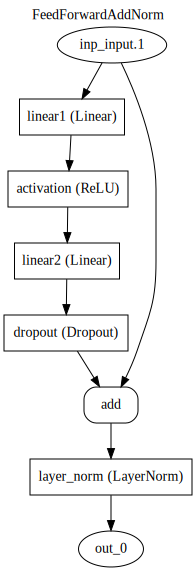

In [127]:
"""Simple test"""
ff = FeedForwardAddNorm(config)
print(ff)
inps = torch.randn(batch_size, config.seq_len, config.d_model)
outs = ff(inps)
assert outs.shape == inps.shape
d = display_module(ff, inps)
d

### 2.2 AttentionAddNorm

Trong phần này bạn sẽ hoàn thành module `AttentionAddNorm` với chiều `forward` như sau:
<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/attention_add_norm.svg" alt="self_attention" style="width:50%">

Với ảnh trên:
- `inp_input.1`, `inp_input.2` và `inp_input.3` đều có shape `(B, seq_len, d_model)`, ứng với `query`, `key`, `value`.
- `inp_mask` là mask của attention, có shape `(B, seq_len, seq_len)`.
- `Q_proj`, `K_proj`, `V_proj` là các `nn.Linear`  $\mathbb{R}^{d_{model} \times  d_{model}}$, tương ứng của `query`, `key` và `value` đầu vào.
- Sau khi qua các projection này, cần reshape (split head) các tensor đó thành `(B, seq_len, n_head, d_k)` trước khi qua `multi_head_attention`.
- `div matmul pow softmaxmasked_fill` là khi gọi `multi_head_attention`.
- Trước khi residual `add`, cần reshape kết quả sau khi dropout về cùng shape với `query`.

Bạn cần:
- Khai báo các thành phần của module `AttentionAddNorm`.
- Khai báo chiều forward.
- Sử dụng các parameters `seq_len`, `d_model`, `n_head`, `d_k`, `attn_dropout` có trong config.

In [128]:
class AttentionAddNorm(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.Q_proj = None
        self.K_proj = None
        self.V_proj = None
        self.dropout = None
        self.layer_norm = None
        ########### YOUR CODE HERE #################
        # seq_len = 512
        # d_model = 512                # d_model = d_k * n_head
        # d_k = 64
        # d_v = 64
        self.Q_proj = nn.Linear(config.d_model, config.d_model)
        self.K_proj = nn.Linear(config.d_model, config.d_model)
        self.V_proj = nn.Linear(config.d_model, config.d_model)
        self.dropout = nn.Dropout(config.attn_dropout)
        self.layer_norm = nn.LayerNorm(config.d_model)
        ###########################################
        
    def forward(self, query, key, value, mask):
        ########### YOUR CODE HERE #################
        config = self.config
        q = self.Q_proj(query)
        q = rearrange(q, 'b n (h d)->b n h d', d=config.d_k)
        k = self.K_proj(key)
        k = rearrange(k, 'b m (h d)->b m h d', d=config.d_k)
        v = self.V_proj(value)
        v = rearrange(v, 'b m (h d)->b m h d', d=config.d_v)

        attn = multi_head_attention_einops(q, k, v, mask)
        attn = rearrange(self.dropout(attn), 'b n h d->b n (h d)')
        x = query + attn
        x = self.layer_norm(x)
        return x
        ###########################################
        pass

AttentionAddNorm(
  (Q_proj): Linear(in_features=512, out_features=512, bias=True)
  (K_proj): Linear(in_features=512, out_features=512, bias=True)
  (V_proj): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
aten::einsum %167 : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::einsum(%165, %166) # /usr/local/lib/python3.7/dist-packages/torch/functional.py:344:0

aten::div %similar_score : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::div(%167, %169) # <ipython-input-122-648187ef7de4>:15:0

aten::masked_fill %input.4 : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::masked_fill(%similar_score, %172, %173) # <ipython-input-122-648187ef7de4>:16:0

aten::softmax %177 : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::softmax(%input.4, %175, %1

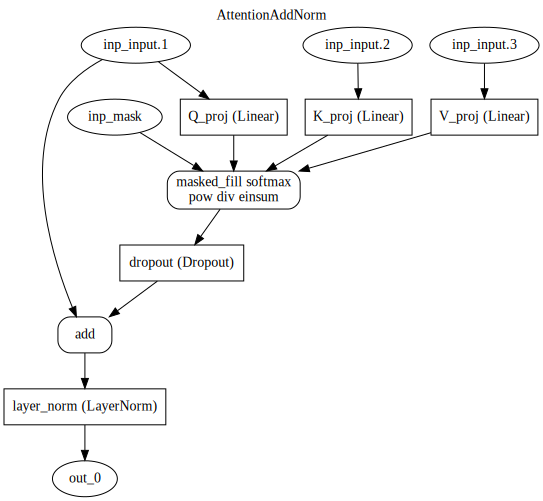

In [129]:
"""Simple test"""
aa = AttentionAddNorm(config)
print(aa)
q = torch.randn(batch_size, config.seq_len, config.d_model)
k = torch.randn(batch_size, config.seq_len, config.d_model)
v = torch.randn(batch_size, config.seq_len, config.d_model)
mask = torch.randint(low=0, high=32, size=(batch_size, config.seq_len, config.seq_len)).eq(3)

outs = aa(q, k, v, mask)
assert outs.shape == q.shape

d = display_module(aa, [q, k, v, mask])
d

### 2.3 EncoderBlock

Một Transformer Encoder (giống với resnet) sẽ gồm nhiều `EncoderBlock` lặp lại, trong phần này bạn sẽ thực hiện `EncoderBlock` với chiều forward như sau:

<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/encoder_block.svg" alt="encoder_block" style="height:40%">

trong đó `self_attention` là module `AttentionAddNorm` bên trên, khi forward nhận `query`, `key` và `value` đều là 1 tensor:
<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/encoder_block_self_attention.svg" alt="self_attention" style="width:90%">

Với ảnh trên:
- Một `EncoderBlock` gồm 2 thành phần: 
  - `self_attention` là module `AttentionAddNorm`, với `query`, `key` và `value` đều từ 1 tensor đầu vào `inp_1`
  - `feed_forward` là module `FeedForwardAddNorm`, nhận đầu vào là output của `self_attention`
- `inp_1` là output của `EncoderBlock` trước, hoặc output của `Embedding`, có shape `(B, seq_len, d_model)`, trong phần forward là `src_embeddings`.
- `inp_mask.1` là mask của các token `PAD` của sequences đầu vào, có shape `(B, seq_len, seq_len)`, trong phần forward là `src_masks`.

Bạn cần:
- Khai báo các thành phần của module `EncoderBlock`.
- Khai báo chiều forward.

In [130]:
class EncoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = None
        self.feed_forward   = None
        ########### YOUR CODE HERE #################
        self.self_attention = AttentionAddNorm(config)
        self.feed_forward   = FeedForwardAddNorm(config)
        ###########################################
        
    def forward(self, src_embeddings, src_masks):
        ########### YOUR CODE HERE #################
        x = src_embeddings
        x = self.self_attention(x, x, x, src_masks)
        return x
        ###########################################
        pass

aten::einsum %141 : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::einsum(%139, %140), scope: __module.self_attention # /usr/local/lib/python3.7/dist-packages/torch/functional.py:344:0

aten::div %similar_score : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::div(%141, %143), scope: __module.self_attention # <ipython-input-122-648187ef7de4>:15:0

aten::masked_fill %input.2 : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::masked_fill(%similar_score, %146, %148), scope: __module.self_attention # <ipython-input-122-648187ef7de4>:16:0

aten::softmax %152 : Float(32:2097152, 8:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::softmax(%input.2, %150, %151), scope: __module.self_attention # /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1512:0

aten::einsum %input.3 : Float(32:262144, 512:64, 8:32768, 64:1, requires_grad=1, device=cpu) = aten::einsum(%153, %154), sco

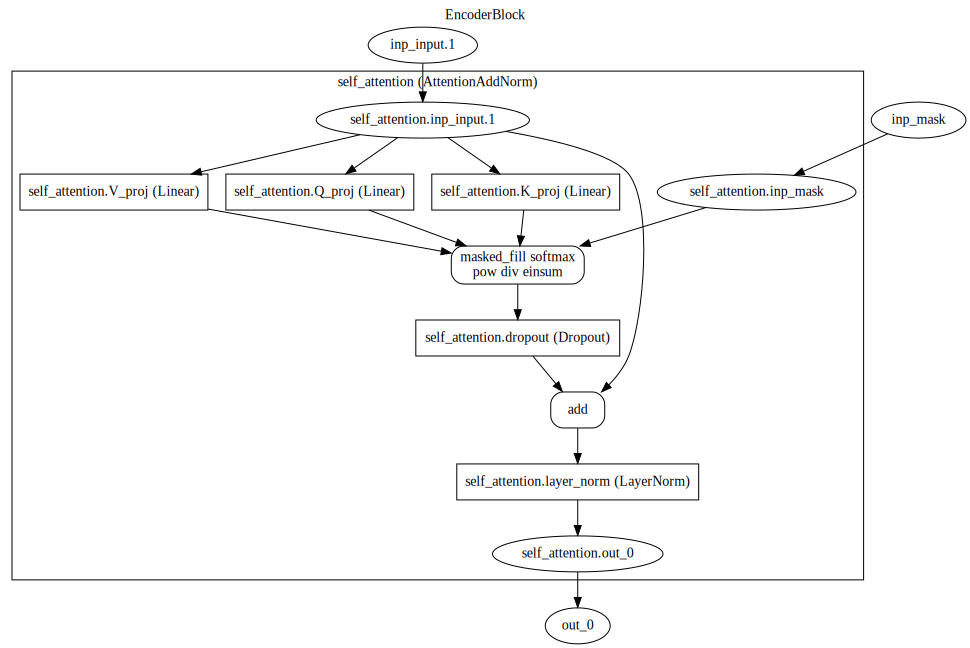

In [131]:
"""Simple test"""
block = EncoderBlock(config)
src_embedding = torch.randn(batch_size, config.seq_len, config.d_model)
src_mask = torch.randint(low=0, high=32, size=(batch_size, config.seq_len, config.seq_len)).eq(3)

outs = block(src_embedding, src_mask)
assert outs.shape == src_embedding.shape
d = display_module(block, [src_embedding, src_mask], classes_to_visit={"AttentionAddNorm"})
d

### 2.4 Embedding

Trong phần này, bạn sẽ hoàn thành module `Embedding` trong Transformers. Module này gồm 2 thành phần:
- `word_embedding`: là `nn.Embedding`, một token sau khi đi qua layer này sẽ được biểu diễn bằng 1 vector có độ dài  `d_model`. Trong transformer, vector này sau đó còn được scale với $\sqrt{d_{model}}$
- `positional_encoding`: Do attention là phép tính không phụ thuộc vào thứ tự, `positional_encoding` là ma trận `seq_len x d_model` được `cộng` vào embedding của từng token để thêm thông tin vị trí tuyệt đối của token trong câu.

Trong phần này bạn cần:
- Hoàn thành hàm `generate_positional_encoding` trả về ma trận `sinusoid`

In [132]:
def generate_positional_encoding(seq_len, d_model):
    """ Return sinusoid matrix `pe` with shape seq_len x d_model
    Arguments:
        seq_len: max number of tokens for a sequence
        d_model: length of vector position
    Return:
        pe: position encoding matrix in Vaswani et al,.
        pe is a matrix with shape (seq_len, d_model)
        and pe[pos_id, feat_id]
         = sin(pos_id/10000^(feat_id / d_model)) if feat_id is even (0, 2, 4,...)
         = cos(pos_id/10000^(feat_id / d_model)) if feat_id is odd  (1, 3, 5,...)
    """
    pe = None
    ########### YOUR CODE HERE #################
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    ###########################################
    return pe

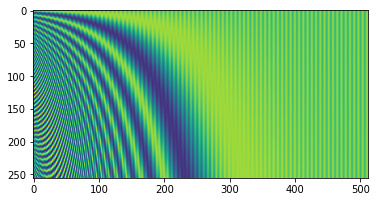

In [133]:
"""Simple test"""
pe = generate_positional_encoding(256, 512)
assert pe.shape == (256, 512)
assert pe[0, 0::2].sum() == 0 
assert pe[0, 1::2].sum() == 512/2
plt.imshow(pe)
plt.show()

Module `Embedding` sẽ có chiều forward như sau:
<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/embedding.svg" alt="embedding" style="height:50%">

Trong ảnh trên:
- `inp_input.1` là torch.LongTensor ids của tokens câu đầu vào, có shape (B, seq_len)
- `word_embedding` là [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer), nhận
- `mul add` là việc scale kết quả của word_embedding với $\sqrt{d_{model}}$, sau đó cộng `element-wise` với `positional_encoding`
- tensor `positional_encoding` sinh từ hàm `generate_positional_encoding`, chỉ khởi tạo **1 lần** trong `__init__`
- tensor `positional_encoding` sẽ **không cập nhật** trong quá trình học, do vậy để lưu lại tensor này vào module `state_dict` nhưng không coi là một parameter để học, cần sử dụng [register_buffer](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer). Đọc thêm [pytorch forums](https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/2)

In [134]:
class Embedding(nn.Module):
    def __init__(self, seq_len, d_model, vocab_size, embed_dropout):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, d_model)
        positional_encoding = (
            torch.tensor(
                generate_positional_encoding(seq_len, d_model), requires_grad=False
            )
            .float()
            .unsqueeze(0)
        )  # (1, seq_len, d_model), to broadcasting add with (B, seq_len, d_model)
        self.register_buffer("positional_encoding", positional_encoding)
        self.dropout = nn.Dropout(embed_dropout)
        self.scale = d_model ** 0.5

    def forward(self, src_ids: torch.LongTensor):
        """Get embeddings with positional information from tokens ids
        Arguments:
            src_ids: torch.LongTensor shape (b, seq_len)

        Return:
            embedding: torch.Tensor shape (b, seq_len, d_model)
        """
        x = self.word_embedding(src_ids) * self.scale
        x = x + self.positional_encoding
        x = self.dropout(x)
        return x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


aten::mul %x : Float(32:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::mul(%28, %13) # <ipython-input-134-26f70ab8b136>:24:0

aten::add %input : Float(32:262144, 512:512, 512:1, requires_grad=1, device=cpu) = aten::add(%x, %24, %15) # <ipython-input-134-26f70ab8b136>:25:0



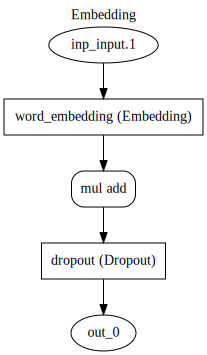

In [135]:
"""Simple test"""
config = TransformersConfig()
emb = Embedding(config.seq_len, config.d_model, config.src_vocab_size, config.embed_dropout)
inp = torch.randint(low=0, high=config.src_vocab_size, size=(batch_size, config.seq_len))
out = emb(inp)
assert out.shape == (batch_size, config.seq_len, config.d_model)
d = display_module(emb, inp)
d

### 2.5 TransformerEncoder

`Embedding` và `EncoderBlock` là 2 thành phần chính tạo nên `TransformerEncoder`, trong phần này bạn sẽ hoàn thành module `TransformerEncoder` với chiều forward như sau (với config `config.num_encoder_layers = 2`):

<img src="https://raw.githubusercontent.com/Luvata/gifs/main/figures/encoder.svg" alt="encoder" style="height750%">

Trong ảnh trên: 
- `blocks` là [nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html), gồm `config.num_encoder_layers` các lớp `EncoderBlock` ở trên
- `inp_input.1` là ids của các tokens đầu vào, shape `(B, seq_len)`
- `inp_mask` là mask của token `PAD` trong `src_ids`, có shape `(B, seq_len, seq_len)`

Bạn cần:
- Khai báo các thành phần của module `TransformerEncoder`
- Khai báo chiều forward giống với ảnh trên
- Các parameters `seq_len`, `d_model`, `n_head`, `num_encoder_layers`, `src_vocab_size` đã có trong config

In [136]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = None
        self.blocks = nn.ModuleList([])
        ########### YOUR CODE HERE #################
        self.embedding = Embedding(config.seq_len, config.d_model, config.src_vocab_size, config.embed_dropout)
        self.blocks = nn.ModuleList([EncoderBlock(config) for i in range(config.num_encoder_layers)]) 
        ###########################################

    def forward(self, src_ids, src_mask):
        ########### YOUR CODE HERE #################
        x = self.embedding(src_ids)
        for block in self.blocks:
            x = block(x, src_mask)
        return x
        ###########################################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


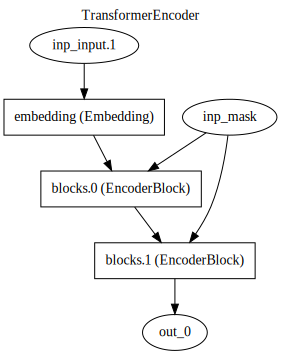

In [137]:
"""Simple test"""
config = TransformersConfig()
inp = torch.randint(low=0, high=config.src_vocab_size, size=(batch_size, config.seq_len))
mask = inp.eq(3).unsqueeze(1).repeat((1, config.seq_len, 1)) # For a sample, all queries (tokens) has same `PAD` mask, so repeat this mask N times
encoder = TransformerEncoder(config)
out = encoder(inp, mask)
assert out.shape == (batch_size, config.seq_len, config.d_model)
d = display_module(encoder, [inp, mask])
d

Như vậy bạn đã hoàn thành `TransformerEncoder`. Bài tập sau bạn sẽ thực hiện xây dựng `TransformerDecoder` và `causal_mask`, đồng thời training mô hình dịch máy sử dụng `TransformerEncoderDecoder`

## References

- Code để visualize phần foward [Thomas Viehmann - visualize-jit-models](https://github.com/t-vi/pytorch-tvmisc/blob/master/hacks/visualize-jit-models.ipynb)
- Code & block ảnh hưởng nhiều từ project [Sasha Rush - The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- Ý tưởng config object từ [Andrej Karpathy - min-gpt](https://github.com/karpathy/minGPT/tree/master/mingpt)